## Data Generator 
Created: February 13, 2020

This series of notebooks generate synthetic data for different components of the food supply chain. It models activities like restaurant orders using normal distributions with parameters number of events $n$, mean $\mu$, and standard deviation $\sigma$.  After the distribution or distributions are is created, a function samples the distribution and generates $n$ events for a specific type of event: telemetry event, event enrichment, or session enrichment event. The events are written to a text file and exported locally. 

This notebook specifically allows a user to specify any number of parameters (3 for normal distribution) for any number of distributions using a textfile. This generates events that are saved and plots a histogram of those events. 

The outputs of the events follows the data model described in this document: https://zumepizza.atlassian.net/wiki/spaces/TERA/pages/615318459/Data+Model

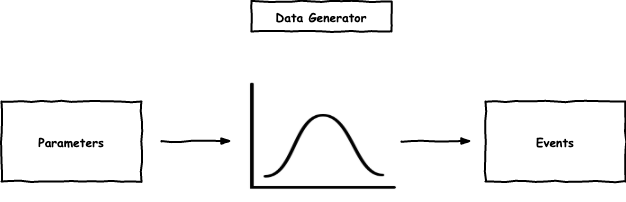

In [1]:
from IPython.display import Image
Image(filename="/Users/newtonkwan/Documents/zume/data-generator/data_generator_pipeline.png")

### Version 1 (2/6/20)
- Shows how to create a normal distribution
- Outputs three text files, each with one of example of the following: telemetry event, enriched event, and enriched session. 

### Version 2 (2/10/20)
- Same as version 1 including the following
- Write three functions that allow a user to specify the number of events to simulate for each of the three kinds of events. The outputs are three text files, each with n number of events of the following kind: telemetry event, enriched event, and enriched session. 

### Version 3 (2/10/20)
- Same as version 2 including the following
- Written a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 
- The event enrichment events generator can generate 100,000 events every 5 seconds and write those events in about 5 seconds for a total of 10 seconds per 100,000 events. 

### Version 4 (2/12/20)
- Same as version 3 including the following
- Written a function that generates synthetic data for Tito's Tacos that has two normal distributions to describe lunch and dinner orders using 6 user specfied parameters (number of lunch orders, number of dinner orders, lunch mean, dinner mean, lunch standard deviation, and dinner standard deviation) to generate data. 
- Added details Part C to telemetry events for orders because I did not consider order details to be event enrichment.
- Plotted a denormlaized normal distribution (amplitude * pdf) rather than normalizing the histogram and fitting it to a pdf because it is more intuitive to view orders of the y-axis than a probability density for number of orders 

### Version 5 (2/12/20)
- Same as version 4 including the following
- Wrote a function that can take in an arbitrary number of sets of parameters (say lunch and dinner or breakfast, lunch, dinner, and dessert).
- Instead of hardcoding in the parameters, a user can specify the parameters in a textfile 
- The readability of the code has been greatly improved by abstracting out the event generating part into its own function, which allows for n number of sets of parameters. 

### Version 6 (2/13/20)
- Same as version 5 including the following
- Explicitly wrote assumptions for the data being generated, including each event being a unique consumer, each event being a unique session, and each event being only one business customer. 
- Added a simple diagram explaining the data generator. 

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy import stats
import json
from datetime import datetime,timezone
from dateutil import tz
import uuid
import random
import time
import os
%config InlineBackend.figure_format = 'retina'

In [ ]:
x = np.linspace(-5, 5, 1000)
mu = 0    # mean 
sigma = 1 # standard deviation
y_pdf = stats.norm.pdf(x, mu, sigma) # the normal pdf 
plt.plot(x, y_pdf, label='pdf')
plt.title("Probability density function (pdf) of a normal distribution")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

The above code shows the basics of using scipy.stats by plotting the normal distribution with mean = 0 and standard deviation = 1 

Create a dictionary to store telemetry events, write it as a json, and save it as a file

In [ ]:
# part A telemetry 
correlation_id = str(uuid.uuid1())
customer = "fred_fruit_farms"
type_of_data = "event"
version = "1.0.0"
source = "telemetry"
UTCtimestamp = str(datetime.now(timezone.utc))

# part B telemetry details
event_type = "view_order_bananas_page"
customer_id = str(uuid.uuid1())
session_id = str(uuid.uuid1())
hub_id = str(uuid.uuid1())
hub_location = str(uuid.uuid1())
menu_version =  str(uuid.uuid1())
experiments = None 
localtime = str(datetime.now(timezone.utc))
UTCeventtime = str(datetime.now(timezone.utc))

In [ ]:
# part B telemetry details
partB_telemetry_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                "customer_id": customer_id, # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                "localtime": localtime,             # The local time this event was generated
                                "UTCtime": UTCeventtime             # The utc time this event was generated
                     }

# part A 
event_dict = {"correlation_id": correlation_id,         # The is the id associated with all telemetry events 
              "customer": customer,                     # The business customer that this row of data was generated for. In the event that the data is generated for internal processes, the customer is Zume. 
              "type": type_of_data,                     # The type of data. Typically "event", which is something generated off of a specific event
              "version": version,                       # The version of this data
              "source": source,                         # Where the data was generated. Often "telemetry", but can be "enrichment".
              "UTCtimestamp": UTCtimestamp,             # A timestamp for when this specific row of data was created 
              "details": partB_telemetry_details_dict,  # Details is where part B data and part C data is stored.   
             }


event_json = json.dumps(event_dict) # converts a python dictionary to a json
print(json.dumps(event_dict, indent=4, sort_keys=False)) # printing a nice format 
with open('telemetry_events.txt', 'w') as file_json: 
    json.dump(event_dict, file_json)

Create a dictionary to store an event that enriches an event, write it as a json, and save it as a file

In [ ]:
# part A event enrichment
correlation_id = str(uuid.uuid1())
customer = "fred_fruit_farms"
type_of_data = "event_enrichment"
version = "1.0.0"
source = "enrichment"
UTCtimestamp = str(datetime.now(timezone.utc))

# part B event enrichment details 
event_type = "view_order_bananas_page_enrichment"
event_version = "001" # this is not included in the data model 
parent_event_type = "view_order_bananas_page"
parent_correlation_id = str(uuid.uuid1())

# part C details 
menu_snapshot = []
for i in range(3):
    d = {"sku": i + 15, 
         "amount": 11,
         "app_position": i, 
         "price": round(random.uniform(2.5,22.5), 2), 
         "category": "main", 
         "subcategory": "fruits", 
         "ux_map": 1 # unclear what this is
        }
    
    menu_snapshot.append(d)
    
    

In [ ]:
# part C event enrichment details
partC_event_enrichment_details_dict = {"menu_snapshot": menu_snapshot
                                      }

# part B event enrichment details
partB_event_enrichment_details_dict = {"event_type": event_type,                        # Every event (part A type) has a event type in part B
                                       "event_version": event_version,                  # This is not currently in the doc 
                                       "parent_event_type": parent_event_type,          # This is an an event enrichment, so this fields denotes what kind of event is being enriched. In this case, the parent event type is view_menu_page.  
                                       "parent_correlation_id": parent_correlation_id,  # Like all event_enrichments, This event enriches a specific event. The parent_correlation_id is used to join to the orignial event. In this case,  we see that the parent event is a menu_view, and the enriched event has details as to what menu was viewed.  
                                       "details": partC_event_enrichment_details_dict   # Details for C 
                                      }

# part A 
indv_enriched_event_dict = {"correlation_id": correlation_id,               # The is the id associated with all telemetry events 
                            "type": type_of_data,                           # The type of data. Typically "event", which is something generated off of a specific event
                            "version": version,                             # The version of this data
                            "source": source,                               # Where the data was generated. Often "telemetry", but can be "enrichment".
                            "UTCtimestamp": UTCtimestamp,                   # A timestamp for when this specific row of data was created 
                            "details": partB_event_enrichment_details_dict  # Details is where part B data and part C data is stored.   
                           }


#event_json = json.dumps(indv_enriched_event_dict) # converts a python dictionary to a json
print(json.dumps(indv_enriched_event_dict, indent=4, sort_keys=False)) # printing a nice format 
with open('enriched_events.txt', 'w') as file_json: 
    json.dump(indv_enriched_event_dict, file_json)

Create a dictionary to store an event that enriches a session, write it as a json, and save it as a file

In [ ]:
# part A session enrichment
correlation_id = str(uuid.uuid1())
type_of_data = "session_enrichment"
version = "1.0.0"
source = "marketing"
UTCtimestamp = str(datetime.now(timezone.utc))

# part B session enrichment details 
event_type = "view_order_bananas_page_enrichment"
event_version = "001" # this is not included in the data model 
parent_session_id = str(uuid.uuid1())

# part C session enrichment details 
campaign_start = "2019-12-15 00:00:00:0000"
campaign_end = "2019-12-31 23:59:59:9999"
markets_targeted = [1232, 5555, 23434, 19101]
total_spend = 55000
expected_impressions_in_current_block = 51233
pview_current_user = .21
expected_impressions_current_user = .64


In [ ]:
# part C event enrichment details
partC_session_enrichment_details_dict = {"campaign_start": campaign_start,
                                         "campaign_end": campaign_end,
                                         "markets_targeted": markets_targeted,
                                         "total_spend": total_spend,
                                         "expected_impressions_in_current_block": expected_impressions_in_current_block,
                                         "pview_current_user": pview_current_user ,
                                         "expected_impressions_current_user": expected_impressions_current_user
                                        }

# part B event enrichment details
partB_session_enrichment_details_dict = {"event_type": event_type,                          # Every event (part A type) has a event type in part B
                                         "event_version": event_version,                    # This is not currently in the doc 
                                         "parent_session_id": parent_session_id,            # the Session ID that this event is augmented to.
                                         "details": partC_session_enrichment_details_dict   # Details for C 
                                        }

# part A 
enriched_session_dict = {"correlation_id": correlation_id,                 # The is the id associated with all telemetry events 
                         "type": type_of_data,                             # The type of data. Typically "event", which is something generated off of a specific event
                         "version": version,                               # The version of this data
                         "source": source,                                 # Where the data was generated. Often "telemetry", but can be "enrichment".
                         "UTCtimestamp": UTCtimestamp,                     # A timestamp for when this specific row of data was created 
                         "details": partB_session_enrichment_details_dict  # Details is where part B data and part C data is stored.   
                           }


#event_json = json.dumps(indv_enriched_event_dict) # converts a python dictionary to a json
print(json.dumps(enriched_session_dict, indent=4, sort_keys=False)) # printing a nice format 
with open('enriched_sessions.txt', 'w') as file_json: 
    json.dump(enriched_session_dict, file_json)

Read a json from a file into a dictionary

In [ ]:
with open('/Users/newtonkwan/Documents/zume/data_generator/enriched_sessions.txt') as file:
    data = json.load(file)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

We now have three files, each with one event: telemetry event, enrichment event, and session enrichment event. Now we want to be able to write a function that allows one to generate an arbitrary number of each kind of event into a file. 

In [ ]:
def generate_telemetry_events(n):
    '''
    Input: n is the number of events to create 
    Output: a dictionary of telemetry events that will then be passed into 
    a function that converts it into a text file. 
    '''
    
    telemetry_events = []
    
    for i in range(n):
        event = {} 
        # part A telemetry 
        correlation_id = str(uuid.uuid1())
        customer = "fred_fruit_farms"
        type_of_data = "event"
        version = "1.0.0"
        source = "telemetry"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B telemetry details
        event_type = "view_order_bananas_page"
        customer_id = str(uuid.uuid1())
        session_id = str(uuid.uuid1())
        hub_id = str(uuid.uuid1())
        hub_location = str(uuid.uuid1())
        menu_version =  str(uuid.uuid1())
        experiments = None 
        localtime = str(datetime.now(timezone.utc))
        UTCeventtime = str(datetime.now(timezone.utc))
        
        # part B telemetry details
        partB_telemetry_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                        "customer_id": customer_id, # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                        "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                        "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                        "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                        "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                        "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                        "localtime": localtime,             # The local time this event was generated
                                        "UTCtime": UTCeventtime             # The utc time this event was generated
                                       }

        # part A 
        event = {"correlation_id": correlation_id,         # The is the id associated with all telemetry events 
                 "customer": customer,                     # The business customer that this row of data was generated for. In the event that the data is generated for internal processes, the customer is Zume. 
                 "type": type_of_data,                     # The type of data. Typically "event", which is something generated off of a specific event
                 "version": version,                       # The version of this data
                 "source": source,                         # Where the data was generated. Often "telemetry", but can be "enrichment".
                 "UTCtimestamp": UTCtimestamp,             # A timestamp for when this specific row of data was created 
                 "details": partB_telemetry_details_dict,  # Details is where part B data and part C data is stored.   
                }
        
        
        
        telemetry_events.append(event)
        
    return telemetry_events
    

In [ ]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

Generate 10 rows of telemetry events to a filename using the telemetry_events and write_to_file functions 

In [ ]:
n = 3
events = generate_telemetry_events(n)
filename = "ten_telemetry_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

In [ ]:
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

Generate 10 rows of event enrichment events to a filename using the generate_event_enrichment_events and write_to_file functions 

In [ ]:
def generate_event_enrichement_events(n):
    '''
    Input: n is the number of events to create 
    Output: a dictionary of event enrichment events that will then be passed into 
    a function that converts it into a text file. 
    '''
    
    event_enrichment_events = []
    
    for i in range(n):
        indv_enriched_event_dict = {} 
        
        # part A event enrichment
        correlation_id = str(uuid.uuid1())
        customer = "fred_fruit_farms"
        type_of_data = "event_enrichment"
        version = "1.0.0"
        source = "enrichment"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B event enrichment details 
        event_type = "view_order_bananas_page_enrichment"
        event_version = "001" # this is not included in the data model 
        parent_event_type = "view_order_bananas_page"
        parent_correlation_id = str(uuid.uuid1())

        # part C details 
        menu_snapshot = []
        for i in range(3):
            d = {"sku": i + 15, 
                 "amount": 11,
                 "app_position": i, 
                 "price": round(random.uniform(2.5,22.5), 2), 
                 "category": "main", 
                 "subcategory": "fruits", 
                 "ux_map": 1 # unclear what this is
                }
            
            menu_snapshot.append(d)
    
    
        
        # part C event enrichment details
        partC_event_enrichment_details_dict = {"menu_snapshot": menu_snapshot
                                              }
        
        # part B event enrichment details
        partB_event_enrichment_details_dict = {"event_type": event_type,                        # Every event (part A type) has a event type in part B
                                               "event_version": event_version,                  # This is not currently in the doc 
                                               "parent_event_type": parent_event_type,          # This is an an event enrichment, so this fields denotes what kind of event is being enriched. In this case, the parent event type is view_menu_page.  
                                               "parent_correlation_id": parent_correlation_id,  # Like all event_enrichments, This event enriches a specific event. The parent_correlation_id is used to join to the orignial event. In this case,  we see that the parent event is a menu_view, and the enriched event has details as to what menu was viewed.  
                                               "details": partC_event_enrichment_details_dict   # Details for C 
                                              }
        
        # part A 
        indv_enriched_event_dict = {"correlation_id": correlation_id,               # The is the id associated with all telemetry events 
                                    "type": type_of_data,                           # The type of data. Typically "event", which is something generated off of a specific event
                                    "version": version,                             # The version of this data
                                    "source": source,                               # Where the data was generated. Often "telemetry", but can be "enrichment".
                                    "UTCtimestamp": UTCtimestamp,                   # A timestamp for when this specific row of data was created 
                                    "details": partB_event_enrichment_details_dict  # Details is where part B data and part C data is stored.   
                                   }

        
        
        
        event_enrichment_events.append(indv_enriched_event_dict)
        
    return event_enrichment_events
    

In [ ]:
n = 3
events = generate_event_enrichement_events(n)
filename = "ten_event_enrichment_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

Generate 10 rows of session enrichment events to a filename using the generate_session_enrichment_events and write_to_file functions 

In [ ]:
def generate_session_enrichement_events(n):
    '''
    Input: n is the number of events to create 
    Output: a list of dictionary of session enrichment events that will then be passed into 
    a function that converts it into a text file. 
    '''
    
    session_enrichment_events = []
    
    for i in range(n):
        indv_session_enrichment_event_dict = {} 
        
        # part A session enrichment
        correlation_id = str(uuid.uuid1())
        type_of_data = "session_enrichment"
        version = "1.0.0"
        source = "marketing"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B session enrichment details 
        event_type = "view_order_bananas_page_enrichment"
        event_version = "001" # this is not included in the data model 
        parent_session_id = str(uuid.uuid1())

        # part C session enrichment details 
        campaign_start = "2019-12-15 00:00:00:0000"
        campaign_end = "2019-12-31 23:59:59:9999"
        markets_targeted = [1232, 5555, 23434, 19101]
        total_spend = 55000
        expected_impressions_in_current_block = 51233
        pview_current_user = .21
        expected_impressions_current_user = .64

    
    
        
        # part C event enrichment details
        partC_session_enrichment_details_dict = {"campaign_start": campaign_start,
                                                 "campaign_end": campaign_end,
                                                 "markets_targeted": markets_targeted,
                                                 "total_spend": total_spend,
                                                 "expected_impressions_in_current_block": expected_impressions_in_current_block,
                                                 "pview_current_user": pview_current_user ,
                                                 "expected_impressions_current_user": expected_impressions_current_user
                                                }
        
        # part B event enrichment details
        partB_session_enrichment_details_dict = {"event_type": event_type,                          # Every event (part A type) has a event type in part B
                                                 "event_version": event_version,                    # This is not currently in the doc 
                                                 "parent_session_id": parent_session_id,            # the Session ID that this event is augmented to.
                                                 "details": partC_session_enrichment_details_dict   # Details for C 
                                                }
        
        # part A 
        enriched_session_dict = {"correlation_id": correlation_id,                 # The is the id associated with all telemetry events 
                                 "type": type_of_data,                             # The type of data. Typically "event", which is something generated off of a specific event
                                 "version": version,                               # The version of this data
                                 "source": source,                                 # Where the data was generated. Often "telemetry", but can be "enrichment".
                                 "UTCtimestamp": UTCtimestamp,                     # A timestamp for when this specific row of data was created 
                                 "details": partB_session_enrichment_details_dict  # Details is where part B data and part C data is stored.   
                                   }

        
        
        
        session_enrichment_events.append(enriched_session_dict)
        
    return session_enrichment_events
    

In [ ]:
n = 3
events = generate_session_enrichement_events(n)
filename = "ten_session_enrichment_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

There are now three functions "generate_telemetry_events()", "generate_event_enrichment_events()", and "generate_session_enrichment_events()" that allow a user to specify the number of simulated events and write them to a file. The functions are still heavily hard coded. The next thing to do is to change the inputs to be based on sampling a distribution. 

Sample from a normal distribution with the ability to change the parameters

In [ ]:
x = np.linspace(1, 12, 1000)
mu, sigma = 7, 1 # mean and standard deviation
n = 1000
samples = np.random.normal(loc=mu, scale=sigma, size=n)
plt.plot(x, samples, label="pdf")

In [ ]:
mu, sigma = 8, 1 # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 50, range=(1, 12), density=True)
print(count)
print(bins)
print(ignored)
plt.plot(bins,1/(sigma * np.sqrt(2 * np.pi)) * 
         np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title("Probability of tomato harvest by month of year")
plt.ylabel("Probability density")
plt.xlabel("Month of year")
plt.show()


In [ ]:
parameters = dict()
distribution = "tomato_harvest_by_month"
mu, sigma = 8, 1
parameters[distribution] = [mu, sigma] 
print(parameters)

for key in parameters.keys():
    print(key)
    
mu, sigma = parameters[distribution][0], parameters[distribution][1] # mean and standard deviation
s = np.random.normal(mu, sigma, 1000)
count, bins, ignored = plt.hist(s, 50, range=(1, 12), density=True)
plt.plot(bins,1/(sigma * np.sqrt(2 * np.pi)) * 
         np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title("Probability Density of Harvesting Tomatoes")
plt.ylabel("Probability Density")
plt.xlabel("Month of Year")
plt.show()


In [ ]:
def generate_tomatoes_harvested_by_month(n, parameters):
    '''
    Input: n --> number of events to simulate; parameters --> a dictionary with the name 
    of the distribution as the key and a list of parameters, specifically mu and sigma, 
    as the value. 
    Output: a list of dictionaries of events of length n with distributions mu and sigma
    '''
    tomato_order_events = [] 
    tomato_harvest_parameters = parameters["tomato_harvest_by_month"]
    mu, sigma = tomato_harvest_parameters[0], tomato_harvest_parameters[1]
    tomato_sampling = [] 
    
    for i in range(n):
        indv_enriched_event_dict = {} 
        
        # part A event enrichment
        correlation_id = str(uuid.uuid1())
        customer = "fred_fruit_and_veggie_farms"
        type_of_data = "event_enrichment"
        version = "1.0.0"
        source = "enrichment"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B event enrichment details 
        event_type = "harvest_tomato_enrichment"
        event_version = "001" # this is not included in the data model 
        parent_event_type = "harvest_tomato"
        parent_correlation_id = str(uuid.uuid1())

        # part C details 
        harvest_snapshot = []
        price_sample = round(random.uniform(0.5,3), 2)
        month_sample = round(np.random.normal(mu, sigma, 1)[0], 2)
        d = {"sku": 1, 
             "amount": 1,
             "price": price_sample, 
             "month": month_sample
             }
            
        harvest_snapshot.append(d)
        tomato_sampling.append(month_sample)
    
        
        # part C event enrichment details
        partC_event_enrichment_details_dict = {"harvest_snapshot": harvest_snapshot
                                              }
        
        # part B event enrichment details
        partB_event_enrichment_details_dict = {"event_type": event_type,                        # Every event (part A type) has a event type in part B
                                               "event_version": event_version,                  # This is not currently in the doc 
                                               "parent_event_type": parent_event_type,          # This is an an event enrichment, so this fields denotes what kind of event is being enriched. In this case, the parent event type is view_menu_page.  
                                               "parent_correlation_id": parent_correlation_id,  # Like all event_enrichments, This event enriches a specific event. The parent_correlation_id is used to join to the orignial event. In this case,  we see that the parent event is a menu_view, and the enriched event has details as to what menu was viewed.  
                                               "details": partC_event_enrichment_details_dict   # Details for C 
                                              }
        
        # part A 
        indv_enriched_event_dict = {"correlation_id": correlation_id,               # The is the id associated with all telemetry events 
                                    "type": type_of_data,                           # The type of data. Typically "event", which is something generated off of a specific event
                                    "version": version,                             # The version of this data
                                    "source": source,                               # Where the data was generated. Often "telemetry", but can be "enrichment".
                                    "UTCtimestamp": UTCtimestamp,                   # A timestamp for when this specific row of data was created 
                                    "details": partB_event_enrichment_details_dict  # Details is where part B data and part C data is stored.   
                                   }

        
        tomato_order_events.append(indv_enriched_event_dict)
        
    return tomato_order_events, tomato_sampling


In [ ]:
n = 1000
mu, sigma = 8, 1
parameters = dict()
distribution = "tomato_harvest_by_month"
parameters[distribution] = [mu, sigma] 
generate_time_start = time.time()
events, samples = generate_tomatoes_harvested_by_month(n, parameters)
generate_time_end = time.time()
#print(events)
#print("")
#print(samples)

generate_time_taken = generate_time_end - generate_time_start 
print("Time to generate", n, "events:", generate_time_taken)
count, bins, ignored = plt.hist(samples, 50, range=(1, 12), density=True)
plt.plot(bins,1/(sigma * np.sqrt(2 * np.pi)) * 
         np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.title("Probability Density of Harvesting Tomatoes")
plt.ylabel("Probability Density")
plt.xlabel("Month of Year")
plt.show()

write_data_start = time.time()
filename = "one_thousand_event_enrichment_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

The generator can create 100,000 events per 5 seconds. I have created a function that generates synthetic data for tomato harvests by month that follows a normal distribution whose parameters can be user specified. 

I'm adapting the generate_tomatoes_harvested_by_month() function to generate_orders_by_hour() for a commissary, which we define as any place that buys ingredients, prepares it, and sells it. 

In [ ]:
parameters = {"lunch_orders":200, "lunch_mean":12.5, "lunch_std":1, 
              "dinner_orders":300, "dinner_mean": 6.5, "dinner_std":1}

In [ ]:
def generate_orders_by_hour(parameters):
    '''
    Input: parameters --> a dictionary with the parameter name as the key, mapped 
    to number of orders n, mean mu, or standard deviation std. 
    Output: a list of dictionaries of events of length n with distributions mu and sigma
    '''
    
    order_events = [] 
    lunch_orders = parameters['lunch_orders']
    lunch_mean = parameters['lunch_mean']
    lunch_std = parameters['lunch_std']
    dinner_orders = parameters['dinner_orders']
    dinner_mean = parameters['dinner_mean']
    dinner_std = parameters['dinner_std']
    
    lunchtime_sampling = [] 
    dinnertime_sampling = []
    
    for i in range(lunch_orders):
        event_dict = {} 
        
        # part A telemetry event
        correlation_id = str(uuid.uuid1())
        customer = "Titos Tacos"
        type_of_data = "event"
        version = "1.0.0"
        source = "telemetry"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B telemetry details
        event_type = "customer_order"
        customer_id = str(uuid.uuid1())
        session_id = str(uuid.uuid1())
        hub_id = str(uuid.uuid1())
        hub_location = str(uuid.uuid1())
        menu_version =  str(uuid.uuid1())
        experiments = None 
        localtime = str(datetime.now(timezone.utc))
        UTCeventtime = str(datetime.now(timezone.utc))

        # part C telemetry details 
        order_snapshot = []
        hour_sample = round(np.random.normal(lunch_mean, lunch_std, 1)[0], 2)
        number_of_skus = random.randint(1,2) # generate 1 or 2 
        if number_of_skus == 1: 
            total = 6.0 
        else: 
            total = 15.50 
        for sku_num in range(number_of_skus):
            if sku_num == 0: 
                subtotal_sample = 6.0 
            else: 
                subtotal_sample = 9.50
            d = {"sku": sku_num+1, 
                 "amount": 1,
                 "subtotal": subtotal_sample,
                 "total": total,
                 "hour of the day": hour_sample
                 }
            order_snapshot.append(d)
            
        lunchtime_sampling.append(hour_sample)
    
        
        # part C event enrichment details
        partC_event_details_dict = {"harvest_snapshot": order_snapshot
                                              }
        
        # part B telemetry details
        partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                    "customer_id": customer_id, # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                    "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                    "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                    "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                    "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                    "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                    "localtime": localtime,             # The local time this event was generated
                                    "UTCtime": UTCeventtime,            # The utc time this event was generated
                                    "details": partC_event_details_dict
                                   }
        
        # part A 
        event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                      "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                      "version": version,                  # The version of this data
                      "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                      "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                      "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                   }

        
        order_events.append(event_dict)
        
        
    for i in range(dinner_orders):
        event_dict = {} 
        
        # part A telemetry event
        correlation_id = str(uuid.uuid1())
        customer = "Titos Tacos"
        type_of_data = "event"
        version = "1.0.0"
        source = "telemetry"
        UTCtimestamp = str(datetime.now(timezone.utc))

        # part B telemetry details
        event_type = "customer_order"
        customer_id = str(uuid.uuid1())
        session_id = str(uuid.uuid1())
        hub_id = str(uuid.uuid1())
        hub_location = str(uuid.uuid1())
        menu_version =  str(uuid.uuid1())
        experiments = None 
        localtime = str(datetime.now(timezone.utc))
        UTCeventtime = str(datetime.now(timezone.utc))

        # part C telemetry details 
        order_snapshot = []
        hour_sample = round(np.random.normal(dinner_mean, dinner_std, 1)[0], 2)
        number_of_skus = random.randint(1,2) # generate 1 or 2 
        if number_of_skus == 1: 
            total = 6.0 
        else: 
            total = 15.50 
        for sku_num in range(number_of_skus):
            if sku_num == 0: 
                subtotal_sample = 6.0 
            else: 
                subtotal_sample = 9.50
            d = {"sku": sku_num+1, 
                 "amount": 1,
                 "subtotal": subtotal_sample,
                 "total": total,
                 "hour of the day": hour_sample
                 }
            order_snapshot.append(d)
            
        dinnertime_sampling.append(hour_sample)
    
        
        # part C event enrichment details
        partC_event_details_dict = {"harvest_snapshot": order_snapshot
                                              }
        
        # part B telemetry details
        partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                    "customer_id": customer_id, # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                    "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                    "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                    "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                    "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                    "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                    "localtime": localtime,             # The local time this event was generated
                                    "UTCtime": UTCeventtime,            # The utc time this event was generated
                                    "details": partC_event_details_dict
                                   }
        
        # part A 
        event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                      "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                      "version": version,                  # The version of this data
                      "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                      "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                      "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                   }

        
        order_events.append(event_dict)
        
    return order_events, lunchtime_sampling, dinnertime_sampling


In [ ]:
lunch_orders = 500
lunch_mean = 12.5
lunch_std = 1
dinner_orders = 800
dinner_mean = 18.5
dinner_std = 1
interval = (8, 22) # 8am to 10pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width

parameters = {"lunch_orders":lunch_orders, "lunch_mean":lunch_mean, "lunch_std":lunch_std, 
              "dinner_orders":dinner_orders, "dinner_mean": dinner_mean, "dinner_std":dinner_std}

generate_time_start = time.time()
events, lunch_samples, dinner_samples = generate_orders_by_hour(parameters)

mu = lunch_mean
sigma = lunch_std 

generate_time_taken = time.time()- generate_time_start 
print("Time to generate", lunch_orders, "events:", generate_time_taken)
amplitude = lunch_orders * dx # number of orders * width of a bin. used to scale distribution

count, bins, ignored = plt.hist(lunch_samples, bins=num_of_bins, range=interval, density=False, color = 'lightcoral', label = "lunch")
pdf = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins,amplitude*pdf,
         linewidth=3, color='red')

mu = dinner_mean
sigma = dinner_std 

amplitude = dinner_orders * dx # number of orders * width of a bin. used to scale distribution
count, bins, ignored = plt.hist(dinner_samples, bins=num_of_bins, range=interval, density=False, color = "slateblue", label = "dinner")
pdf = stats.norm.pdf(bins, mu, sigma)
plt.plot(bins,amplitude*pdf, linewidth=3, color='indigo')
plt.title("Distribution of Orders")
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()

write_data_start = time.time()
filename = "titos_tacos_order_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

I have a function now that allows me to generate order data in the form of telemetry events for Tito's Tacos using two normal distributions for lunch and dinner, where the user can specify the parameters (number of orders, mean, and standard deviation) for lunch and dinner, totalling to 6 parameters. Now, I want to write a function that encapsulates plotting the samples and distributions. I also want to change the color of the histograms. I want to create a function that takes in the parameters for a distribution and returns sampling and the events for that period of time. I also want to be able to generate data at the end that someone could actually look at if i sent to them, meaning that parent IDs will have to match up. In addition, I want a way to send a text file to the function specifying what kind of data someone wants and then outputting that data. 

In [2]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

In [3]:
def sample_distributions(num_of_orders, mu, sigma):
    '''
    This function takes three parameters, creates a distribution, and samples that 
    distribution to create events 
    Input: number of orders, the mean mu, and the standard deviation sigma 
    Output: returns n events in a list and 
    '''
    events = [] 
    samples = []
    
    for i in range(num_of_orders):
        event_dict = {} 
        
        # setting up variables
        from_zone = tz.tzutc()
        to_zone = tz.lzlocal()
        utc = datetime.utcnow() 
        utc = utc.replace(tzinfo=from_zone)
        local = utc.astimezone(to_zone)
        
        # part A telemetry event
        correlation_id = str(uuid.uuid1())   # will always be unique for each event 
        customer = "Titos Tacos"             # changes based on customer
        type_of_data = "event"              
        version = "1.0.0"
        source = "telemetry"
        UTCtimestamp = str(utc)              # convert it into a string

        # part B telemetry details
        event_type = "customer_order"
        customer_id = str(uuid.uuid1())      # mapping to the customer
        session_id = str(uuid.uuid1())
        hub_id = str(uuid.uuid1())
        hub_location = str(uuid.uuid1())
        menu_version =  "1.0.0"
        experiments = None 
        localtime = str(local)
        UTCeventtime = str(utc)

        # part C telemetry details 
        order_snapshot = []
        hour_sample = round(np.random.normal(mu, sigma, 1)[0], 2)
        number_of_skus = random.randint(1,2) # generate 1 or 2 
        if number_of_skus == 1: 
            total = 6.0 
        else: 
            total = 15.50 
        for sku_num in range(number_of_skus):
            if sku_num == 0: 
                subtotal_sample = 6.0 
            else: 
                subtotal_sample = 9.50
            d = {"sku": sku_num+1, 
                 "amount": 1,
                 "subtotal": subtotal_sample,
                 "total": total,
                 "hour of the day": hour_sample
                 }
            order_snapshot.append(d)
            
        samples.append(hour_sample)
    
        
        # part C event enrichment details
        partC_event_details_dict = {"order_snapshot": order_snapshot
                                              }
        
        # part B telemetry details
        partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                    "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                    "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                    "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                    "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                    "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                    "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                    "localtime": localtime,             # The local time this event was generated
                                    "UTCtime": UTCeventtime,            # The utc time this event was generated
                                    "details": partC_event_details_dict
                                   }
        
        # part A 
        event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                      "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                      "version": version,                  # The version of this data
                      "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                      "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                      "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                   }
        events.append(event_dict)
    return events, samples

In [4]:
def generate_orders_by_hour(parameters):
    '''
    This function generates events of based on distributions parametrized by parameters 
    Input: parameters is list of lists of string parameters in the format [orders, mu, sigma]
    Output: a list of order_events and a list of lists of order samples
    '''
    
    order_events = [] 
    order_samples = [] 

    for p in parameters: 
        num_orders = p[0] 
        mu = p[1]
        sigma = p[2]
        events, samples = sample_distributions(num_orders, mu, sigma)
        order_events += events
        order_samples.append(samples) 
        
    return order_events, order_samples


In [ ]:
plt.figure(figsize=(10,5))

with open("parameters.txt") as f: 
    raw = f.read().splitlines()[2:]

parameters = []
for p in raw: 
    nth_params = list(map(float, p.split(",")))
    nth_params[0] = int(nth_params[0])
    parameters.append(nth_params)
    
interval = (5, 24) # 6am to 11pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width


generate_time_start = time.time()
events, order_samples = generate_orders_by_hour(parameters)
generate_time_taken = time.time() - generate_time_start 

print("Time to generate", len(events), "events:", round(generate_time_taken, 3), "seconds")
colors = [["black", "wheat"], ["slateblue", "indigo"], ["steelblue", "dodgerblue"], ["lightcoral", "red"]]

for samples, p in zip(order_samples, parameters): 
    number_of_orders = p[0]
    mu = p[1]
    sigma = p[2]
    amplitude = number_of_orders * dx # number of orders * width of a bin. used to scale 
    if colors != []:
        color = colors.pop()
    else: 
        color = ("darkorange", "yellowgreen")
    count, bins, ignored = plt.hist(samples, bins=num_of_bins, 
                                    range=interval, color = color[0], 
                                    label = "\u03BC = {:.2f}, \u03C3 = {:.2f}".format(mu, sigma))
    pdf = stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins,amplitude*pdf, linewidth=3, color=color[1])

plt.title("Distribution of Orders")
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()

write_data_start = time.time()
filename = "v6_titos_tacos_order_events.txt"
write_to_file(events, filename)
with open('/Users/newtonkwan/Documents/zume/data_generator/' + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

I wrote a function that takes in a textfile of parameters that allows for an arbitrary number of sets of parameters to include in the order distribution. Up to 4 distinct colors, but will default to other colors in the case where there are more than 4 sets of parameters. I also rewrote a function that allows the for arbitrary number of paramters inside of the event generator. 

In [5]:
def write_to_file(events, filename):
    '''
    Converts a list of dictionaries into json events saved as a text file as filename
    Input: Events is a list of events dictionaries and filename is a string
    Output: Print number of events written and filename 
    '''
    n = len(events)
    with open(filename, 'w') as file_json: 
        json.dump(events, file_json)
    
    print("Successfully created the file", filename, "with", n, "events")
    return 

In [6]:
def sample_distributions(num_of_orders, mu, sigma):
    '''
    This function takes three parameters, creates a distribution, and samples that 
    distribution to create a list of events. 
    Ex: [100, 6, 1]
    The function would create a normal distribution with n = 100, mean = 6, and 
    standard deviation = 1, sample the distribution 100 times, creating 100 events 
    in the format of the data model. It will return a list of these events 
    
    Input: number of orders, the mean mu, and the standard deviation sigma 
    Output: returns n events in a list 
    '''
    events = [] 
    samples = []
    
    # assumptions
    # customer is the same for all events 
    customer = "Titos Tacos"       
    
    # the hub is always the same 
    hub_id = str(uuid.uuid1())   
    
    # the session is always unique per event  
    
    for i in range(num_of_orders):
        event_dict = {} 
        
        # setting up variables
        from_zone = tz.tzutc()
        to_zone = tz.tzlocal()
        utc = datetime.utcnow() 
        utc = utc.replace(tzinfo=from_zone)
        local = utc.astimezone(to_zone)
        
        # part A telemetry event
        correlation_id = str(uuid.uuid1())   # will always be unique for each event 
        customer = "Titos Tacos"             # business customer the row was generated for
        type_of_data = "event"              
        version = "1.0.0"
        source = "telemetry"
        UTCtimestamp = str(utc)              # convert it into a string

        # part B telemetry details
        event_type = "customer_order"
        customer_id = str(uuid.uuid1())      # ID of a specific customer 
        session_id = str(uuid.uuid1())
        hub_id = hub_id                      # unique to the restaurant location
        hub_location = None                  # None if it's stationary
        menu_version =  "1.0.0"
        experiments = None 
        localtime = str(local)
        UTCeventtime = str(utc)

        # part C telemetry details 
        order_snapshot = []
        hour_sample = round(np.random.normal(mu, sigma, 1)[0], 2)
        number_of_skus = random.randint(1,2) # generate 1 or 2 
        if number_of_skus == 1: 
            total = 6.0 
        else: 
            total = 15.50 
        for sku_num in range(number_of_skus):
            if sku_num == 0: 
                subtotal_sample = 6.0 
            else: 
                subtotal_sample = 9.50
            d = {"sku": sku_num+1, 
                 "amount": 1,
                 "subtotal": subtotal_sample,
                 "total": total,
                 "hour of the day": hour_sample
                 }
            order_snapshot.append(d)
            
        samples.append(hour_sample)
    
        
        # part C telemetry details
        partC_event_details_dict = {"order_snapshot": order_snapshot
                                              }
        
        # part B telemetry details
        partB_event_details_dict = {"event_type": event_type,           # Every event (part A type) has a event type in part B
                                    "customer_id": customer_id,         # The ID for a specific customer. This is null if a customer is not logged in or we cannot find it 
                                    "session_id": session_id,           # An ID that joins a set of events into a specific customer session. 
                                    "hub_id": hub_id,                   # The ID for the specific Hub (kiosk, etc.) that is being viewed
                                    "hub_location": hub_location,       # The location of the specific hub. For hub's in which the location does not every change, such as a fixed Kiosk, this field will be null as location can be obtained through a lookup
                                    "menu_version": menu_version,       # You can lookup details about this menu with this id.  
                                    "experiments": experiments,         # If a user is in an experiment, it would be represented here in the format experiment:treatment with pipe delimitation.  E.G. if the user was in treatment 2 of a ux experiment titled redbuttons, and treatment 12 of an experiment titled aggressivemarketing, the field would be "redbuttons:2|aggressivemarketing:12
                                    "localtime": localtime,             # The local time this event was generated
                                    "UTCtime": UTCeventtime,            # The utc time this event was generated
                                    "details": partC_event_details_dict
                                   }
        
        # part A 
        event_dict = {"correlation_id": correlation_id,    # The is the id associated with all telemetry events 
                      "customer": customer,
                      "type": type_of_data,                # The type of data. Typically "event", which is something generated off of a specific event
                      "version": version,                  # The version of this data
                      "source": source,                    # Where the data was generated. Often "telemetry", but can be "enrichment".
                      "UTCtimestamp": UTCtimestamp,        # A timestamp for when this specific row of data was created 
                      "details": partB_event_details_dict  # Details is where part B data and part C data is stored.   
                                   }
        events.append(event_dict)
    return events, samples

In [7]:
def generate_orders_by_hour(parameters):
    '''
    This function generates events based on distributions parametrized by parameters 
    Input: parameters is list of lists of string parameters in the format [orders, mu, sigma]
    Output: a list of order_events and a list of lists of order samples
    '''
    
    order_events = [] 
    order_samples = [] 

    for p in parameters: 
        num_orders = p[0] 
        mu = p[1]
        sigma = p[2]
        events, samples = sample_distributions(num_orders, mu, sigma)
        order_events += events
        order_samples.append(samples) 
        
    return order_events, order_samples


Time to generate 650 events: 0.064 seconds


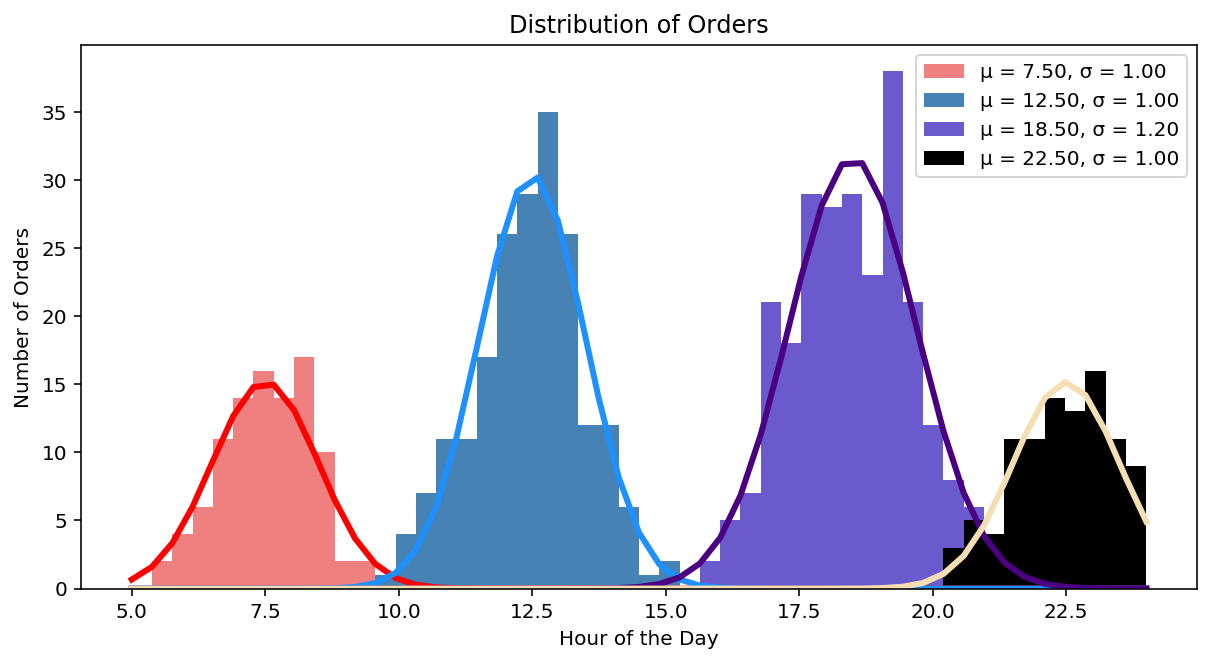

Successfully created the file notebook_v6_titos_tacos_order_events.txt with 650 events
Time to write json: 0.0388948917388916
[
    {
        "correlation_id": "f6aa943a-529c-11ea-ae97-acde48001122",
        "customer": "Titos Tacos",
        "type": "event",
        "version": "1.0.0",
        "source": "telemetry",
        "UTCtimestamp": "2020-02-18 22:21:09.497073+00:00",
        "details": {
            "event_type": "customer_order",
            "customer_id": "f6aa94ee-529c-11ea-ae97-acde48001122",
            "session_id": "f6aa952a-529c-11ea-ae97-acde48001122",
            "hub_id": "f6aa8f62-529c-11ea-ae97-acde48001122",
            "hub_location": null,
            "menu_version": "1.0.0",
            "experiments": null,
            "localtime": "2020-02-18 14:21:09.497073-08:00",
            "UTCtime": "2020-02-18 22:21:09.497073+00:00",
            "details": {
                "order_snapshot": [
                    {
                        "sku": 1,
                    

In [8]:
plt.figure(figsize=(10,5))
current_directory = os.getcwd()

with open(current_directory + "/" + "parameters.txt") as f: 
    raw = f.read().splitlines()[2:]

parameters = []
for p in raw: 
    nth_params = list(map(float, p.split(",")))
    nth_params[0] = int(nth_params[0])
    parameters.append(nth_params)
    
interval = (5, 24) # 6am to 11pm 
num_of_bins = 50
dx = (interval[1] - interval[0]) / num_of_bins # interval length / number of bins = bin_width


generate_time_start = time.time()
events, order_samples = generate_orders_by_hour(parameters)
generate_time_taken = time.time() - generate_time_start 

print("Time to generate", len(events), "events:", round(generate_time_taken, 3), "seconds")
colors = [["black", "wheat"], 
          ["slateblue", "indigo"], 
          ["steelblue", "dodgerblue"], 
          ["lightcoral", "red"]]

for samples, p in zip(order_samples, parameters): 
    number_of_orders = p[0]
    mu = p[1]
    sigma = p[2]
    amplitude = number_of_orders * dx # number of orders * width of a bin. used to scale 
    if colors != []:
        color = colors.pop()
    else: 
        color = ("darkorange", "yellowgreen")
    count, bins, ignored = plt.hist(samples, bins=num_of_bins, 
                                    range=interval, color = color[0], 
                                    label = "\u03BC = {:.2f}, \u03C3 = {:.2f}".format(mu, sigma))
    pdf = stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins,amplitude*pdf, linewidth=3, color=color[1])

plt.title("Distribution of Orders")
plt.ylabel("Number of Orders")
plt.xlabel("Hour of the Day")
plt.legend()
plt.show()

write_data_start = time.time()
save_directory = os.getcwd()
filename = "notebook_v6_titos_tacos_order_events.txt"
write_to_file(events, filename)
with open(save_directory + "/" + filename) as file:
    data = json.load(file)

write_data_end = time.time()
write_time_taken = write_data_end - write_data_start 
print("Time to write json:", write_time_taken)

print(json.dumps(data, indent=4, sort_keys=False)) # printing a nice format 

I can generate events for a given number of orders by distribution. I made a lot of assumptions about the events generated. For example, each event is always a unique customer, each event only has one type of event type, namely "customer_order", there are no repeat customers, every event is a unique session and has at most one event. 

I want to do away with some of those assumptions (or at least capture them in a distribution). I'll do this by first generating synthetic customers that generate synthetic events. 